# Landuse accessibility from OSM data

Calculate landuse accessibilities from OSM data.

This examples calculates landuse accessibility to pubs and restaurants for London


In [1]:
from cityseer.metrics import layers
from cityseer.tools import graphs, io
import matplotlib.pyplot as plt
from osmnx import features

In [2]:
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 1500
poly_wgs, epsg_code = io.buffered_point_poly(lng, lat, buffer)
G = io.osm_graph_from_poly(poly_wgs)
G_dual = graphs.nx_to_dual(G)
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(G_dual)

INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
INFO:cityseer.tools.io:Converting networkX graph to CRS code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating 

Prepare the amenities GeoDataFrame.

# convert to the same UTM CRS as the network

# to match EPSG code for UTM zone 30N per network data


In [3]:
data_gdf = features.features_from_polygon(
    poly_wgs, tags={"amenity": ["pub", "restaurant"]}
)
data_gdf = data_gdf.to_crs(nodes_gdf.crs)
data_gdf

geometry  \
element id                                                              
node    21593236                       POINT (699869.619 5711280.678)   
        25471087                         POINT (699749.16 5710787.29)   
        25475914                       POINT (699606.322 5711699.239)   
        25746185                         POINT (700308.36 5710758.42)   
        26699558                       POINT (699071.215 5711168.671)   
...                                                               ...   
way     995954627   POLYGON ((699270.101 5710540.727, 699277.571 5...   
        1016903732  POLYGON ((699039.571 5710804.095, 699036.453 5...   
        1060462032  POLYGON ((700144.125 5710144.723, 700142.327 5...   
        1072559143  POLYGON ((699383.906 5710631.863, 699382.376 5...   
        1194233515  POLYGON ((700109.233 5711375.71, 700111.379 57...   

                   addr:city addr:country addr:housenumber addr:postcode  \
element id                                                                 
node    21593236      London           GB               12      WC2A 3HP   
        25471087      London          NaN               39           NaN   
        25475914         NaN          NaN              NaN           NaN   
        25746185      London          NaN              NaN      WC2R 3LD   
        26699558         NaN          NaN              NaN           NaN   
...                      ...          ...              ...           ...   
way     995954627     London          NaN               24      WC2H 0HX   
        1016903732       NaN          NaN              NaN           NaN   
        1060462032    London          NaN              NaN       SE1 8XX   
        1072559143    London          NaN               17      WC2E 9AX   
        1194233515    London          NaN          283-288      WC1V 7HP   

                           addr:street     amenity  check_date  \
element id                                                       
node    21593236           Gate Street         pub  2023-04-18   
        25471087            Bow Street         pub         NaN   
        25475914                   NaN         pub         NaN   
        25746185                   NaN         pub         NaN   
        26699558                   NaN         pub  2024-09-10   
...                                ...         ...         ...   
way     995954627   Charing Cross Road  restaurant  2024-10-07   
        1016903732                 NaN  restaurant         NaN   
        1060462032      Belvedere Road  restaurant         NaN   
        1072559143      Garrick Street  restaurant         NaN   
        1194233515        High Holborn         pub  2023-08-03   

                               contact:email     contact:phone  ... gift  \
element id                                                      ...        
node    21593236    info@theshiptavern.co.uk  +44 20 7405 1992  ...  NaN   
        25471087                         NaN               NaN  ...  NaN   
        25475914                         NaN               NaN  ...  NaN   
        25746185                         NaN               NaN  ...  NaN   
        26699558                         NaN               NaN  ...  NaN   
...                                      ...               ...  ...  ...   
way     995954627                        NaN               NaN  ...  NaN   
        1016903732                       NaN               NaN  ...  NaN   
        1060462032                       NaN               NaN  ...  NaN   
        1072559143                       NaN  +44 20 3675 0930  ...  NaN   
        1194233515                       NaN  +44 20 7242 5669  ...  NaN   

                   access:conditional note:access name:gsw note:name:en  \
element id                                                                
node    21593236                  NaN         NaN      NaN          NaN   
        25471087                  NaN         NaN

In [4]:
# extract nodes
data_gdf = data_gdf.loc["node"]
# reset index
data_gdf = data_gdf.reset_index(level=0, drop=True)
# extract relevant columns
data_gdf = data_gdf[["amenity", "geometry"]]
data_gdf

,amenity,geometry
0,pub,POINT (699869.619 5711280.678)
1,pub,POINT (699749.16 5710787.29)
2,pub,POINT (699606.322 5711699.239)
3,pub,POINT (700308.36 5710758.42)
4,pub,POINT (699071.215 5711168.671)
...,...,...
697,restaurant,POINT (698734.983 5712225.281)
698,restaurant,POINT (699919.63 5711570.79)
699,restaurant,POINT (698469.249 5710542.417)
700,restaurant,POINT (699644.903 5710197.532)


In [5]:
# compute pub accessibility
distances = [100, 200, 400, 800]
nodes_gdf, data_gdf = layers.compute_accessibilities(
    data_gdf,
    landuse_column_label="amenity",
    accessibility_keys=["pub", "restaurant"],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=distances,
)

INFO:cityseer.metrics.layers:Computing land-use accessibility for: pub, restaurant
INFO:cityseer.metrics.layers:Assigning data to network.
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 100m, Beta: 0.04, Walking Time: 1.25 minutes.
INFO:cityseer.config:Distance: 200m, Beta: 0.02, Walking Time: 2.5 minutes.
INFO:cityseer.config:Distance: 400m, Beta: 0.01, Walking Time: 5.0 minutes.
INFO:cityseer.config:Distance: 800m, Beta: 0.005, Walking Time: 10.0 minutes.


In [6]:
nodes_gdf.columns

Index(['ns_node_idx', 'x', 'y', 'live', 'weight', 'primal_edge',
       'primal_edge_node_a', 'primal_edge_node_b', 'primal_edge_idx',
       'dual_node', 'cc_pub_100_nw', 'cc_pub_100_wt', 'cc_pub_200_nw',
       'cc_pub_200_wt', 'cc_pub_400_nw', 'cc_pub_400_wt', 'cc_pub_800_nw',
       'cc_pub_800_wt', 'cc_pub_nearest_max_800', 'cc_restaurant_100_nw',
       'cc_restaurant_100_wt', 'cc_restaurant_200_nw', 'cc_restaurant_200_wt',
       'cc_restaurant_400_nw', 'cc_restaurant_400_wt', 'cc_restaurant_800_nw',
       'cc_restaurant_800_wt', 'cc_restaurant_nearest_max_800'],
      dtype='object')

The output GeoDataFrame will contain new columns for each landuse and distance combination. For each of these the following will have been computed:

- A count of reachable instances of a given landuse (within the specified distance thresholds)
- Similarly, a distance-weighted count of reachable locations
- The distance to the nearest instance of a given landuse. Where there are no reachable landuses for a given node within the specified distance threshold, then a `np.inf` value will be returned.


(np.float64(697035.8123208123),
 np.float64(700647.6928482385),
 np.float64(5709134.052621752),
 np.float64(5712638.694212982))

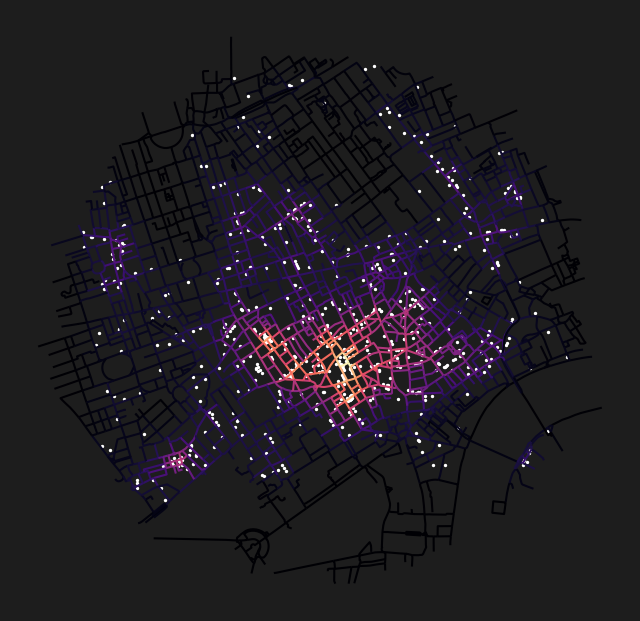

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_restaurant_400_wt",
    cmap="magma",
    legend=False,
    ax=ax,
)
data_gdf[data_gdf["amenity"] == "restaurant"].plot(
    markersize=2,
    edgecolor=None,
    color="white",
    legend=False,
    ax=ax,
)
ax.axis(False)


(np.float64(697035.8123208123),
 np.float64(700647.6928482385),
 np.float64(5709196.424057339),
 np.float64(5712635.724144622))

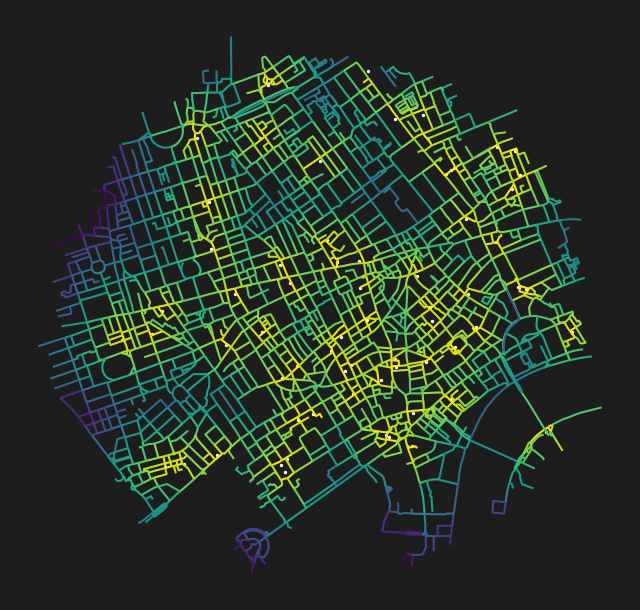

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_pub_nearest_max_800",
    cmap="viridis_r",
    legend=False,
    ax=ax,
)
data_gdf[data_gdf["amenity"] == "pub"].plot(
    markersize=2,
    edgecolor=None,
    color="white",
    legend=False,
    ax=ax,
)
ax.axis(False)